In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('/Users/wonminkim/Projects/DATCapstone/data2/data.csv', index_col=0)
df['Date'] = pd.to_datetime(df['Date'])

# # Forward fill micro, macro, stock
# df[df.columns[1:40]] = df[df.columns[1:40]].ffill()
# # Fill 0 to sentiment
# df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

# df[df.columns[1:-5]] = df.groupby('Ticker')[df.columns[1:-5]].ffill()

df[df.columns[1:40]] = df.groupby('Ticker')[df.columns[1:40]].ffill()
df[df.columns[40:-5]] = df[df.columns[40:-5]].fillna(0)

df = df.dropna(subset=df.columns[0:-5])

In [25]:
df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_763,emb_764,emb_765,emb_766,emb_767,Target_1day,Target_1week,Target_1month,Target_1year,Ticker
21,2021-06-30,262.336071,262.985377,261.279713,262.539581,21656500,0.0,0.0,23368.861,5.9,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.678406,6.318787,15.118530,-11.945328,MSFT
23,2021-07-01,261.289382,263.450571,261.279710,263.217987,16725300,0.0,0.0,23921.991,5.4,...,0.000000,0.000000,0.000000,0.000000,0.000000,5.863251,6.144318,12.899200,-8.930466,MSFT
25,2021-07-02,264.400313,269.420442,264.090182,269.081238,26458000,0.0,0.0,23921.991,5.4,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.009674,-0.319733,6.948761,-18.145035,MSFT
27,2021-07-06,269.449488,270.748130,265.834592,269.090912,31565600,0.0,0.0,23921.991,5.4,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.199951,3.217560,9.168060,-15.467819,MSFT
29,2021-07-07,270.777221,272.027418,268.596660,271.290863,23260000,0.0,0.0,23921.991,5.4,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.432495,2.500366,6.377014,-14.472809,MSFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8095,2025-01-31,236.500000,240.289993,236.410004,237.679993,36162400,0.0,0.0,29723.864,4.0,...,0.242517,-0.188160,-0.536730,-0.404883,0.614863,NaN,NaN,NaN,NaN,AMZN
8096,2025-01-31,218.997334,226.115794,215.647470,220.602478,41151000,0.0,0.0,29723.864,4.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,AVGO
8097,2025-01-31,201.767628,205.243621,201.567861,203.785309,32042000,0.0,0.0,29723.864,4.0,...,0.707091,-0.305774,-0.334049,-0.197861,0.743848,NaN,NaN,NaN,NaN,GOOGL
8099,2025-01-31,418.141600,419.848170,414.079737,414.229431,34223400,0.0,0.0,29723.864,4.0,...,0.744444,-0.874127,-0.850657,-0.140685,0.215989,NaN,NaN,NaN,NaN,MSFT


In [26]:
# 정렬
df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

# lag 생성 대상 컬럼과 시차
lag_cols = df.columns[1:44]
lags = [1, 3, 5, 7, 14, 30]

# lag feature를 저장할 리스트
lag_features = []

# lag된 컬럼들 생성
for col in lag_cols:
    for lag in lags:
        lagged = df.groupby('Ticker')[col].shift(lag)
        lag_features.append(lagged.rename(f'{col}_lag{lag}'))

# lag된 컬럼들 DataFrame으로 병합
lag_df = pd.concat(lag_features, axis=1)

# 원본 df와 합치기
df = pd.concat([df.reset_index(drop=True), lag_df.reset_index(drop=True)], axis=1)

# 필요 시 결측치 제거
df = df.dropna().reset_index(drop=True)

In [27]:
from sklearn.decomposition import PCA

# 1. PCA 적용
pca = PCA(n_components=0.95, random_state=42)
emb_cols = [col for col in df.columns if col.startswith("emb_")]
X_emb = df[emb_cols]
X_emb_pca = pca.fit_transform(X_emb)

# 2. PCA 결과를 emb_pca_ 접두사 붙여서 DataFrame으로 변환
pca_columns = [f"emb_pca_{i}" for i in range(X_emb_pca.shape[1])]
df_pca_part = pd.DataFrame(X_emb_pca, columns=pca_columns, index=df.index)

# 3. 원래 데이터에서 emb_ 컬럼 제거
df_non_pca = df.drop(columns=emb_cols)

# 4. 두 DataFrame 합치기
df_pca = pd.concat([df_non_pca.reset_index(drop=True), df_pca_part.reset_index(drop=True)], axis=1)

# 결과 확인
df_pca.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,GDP (Billions USD),Unemployment Rate (%),...,emb_pca_51,emb_pca_52,emb_pca_53,emb_pca_54,emb_pca_55,emb_pca_56,emb_pca_57,emb_pca_58,emb_pca_59,emb_pca_60
0,2021-11-11,146.398277,146.860181,145.140276,145.327011,41000000,0.0,0.0,24777.038,4.2,...,0.000835,0.000174,-0.00003,-0.000127,-0.00033,0.000351,-0.00079,-0.000211,-0.000162,-0.000155
1,2021-11-12,145.877399,147.813521,144.943739,147.410583,63804000,0.0,0.0,24777.038,4.2,...,0.000835,0.000174,-0.00003,-0.000127,-0.00033,0.000351,-0.00079,-0.000211,-0.000162,-0.000155
2,2021-11-15,147.784058,149.268100,146.860221,147.420425,59222800,0.0,0.0,24777.038,4.2,...,0.000835,0.000174,-0.00003,-0.000127,-0.00033,0.000351,-0.00079,-0.000211,-0.000162,-0.000155
3,2021-11-16,147.361460,148.884808,146.771772,148.403229,59256200,0.0,0.0,24777.038,4.2,...,0.000835,0.000174,-0.00003,-0.000127,-0.00033,0.000351,-0.00079,-0.000211,-0.000162,-0.000155
4,2021-11-17,148.403219,152.334430,148.393396,150.850403,88807000,0.0,0.0,24777.038,4.2,...,0.000835,0.000174,-0.00003,-0.000127,-0.00033,0.000351,-0.00079,-0.000211,-0.000162,-0.000155


In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def random_forest(data, target):
    df = data.copy()
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)

    # Drop other Targets and NaNs
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # Date processing
    df['Date'] = pd.to_datetime(df['Date'])

    # One-hot encode Ticker
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 정규화
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 하이퍼파라미터 그리드 설정
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20]
    }

    # GridSearchCV 설정
    grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                               param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               n_jobs=-1,
                               verbose=1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 예측
    y_pred = best_model.predict(X_test)

    # 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 10, 'n_estimators': 100}

 Evaluation:
Mean Squared Error (MSE): 11.2357
Mean Absolute Error (MAE): 2.1597
R² Score: -0.3524


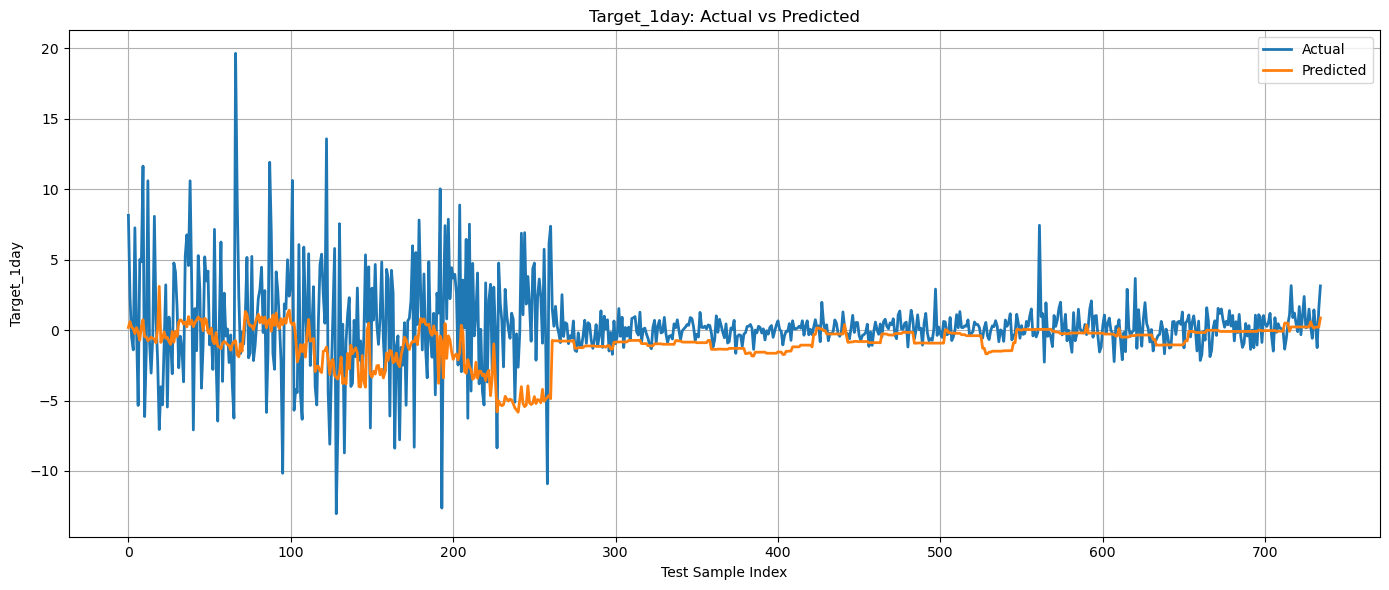

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': 20, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 37.7267
Mean Absolute Error (MAE): 4.0327
R² Score: -0.0960


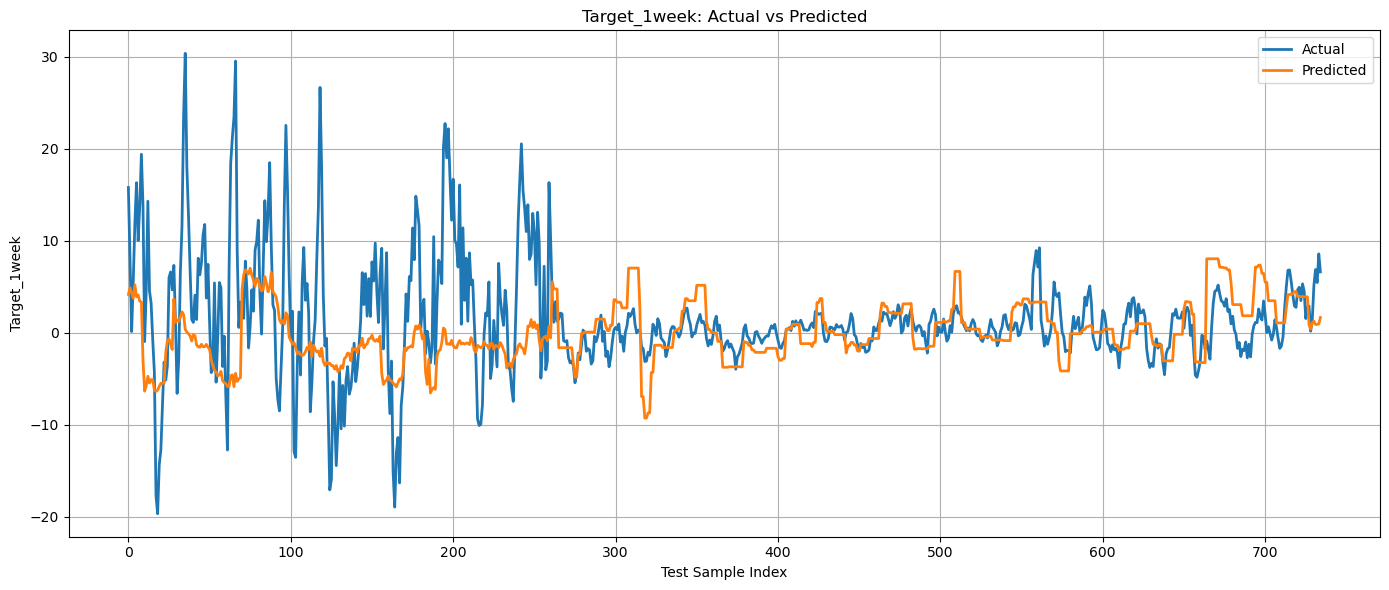

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': None, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 136.3814
Mean Absolute Error (MAE): 7.6984
R² Score: 0.0378


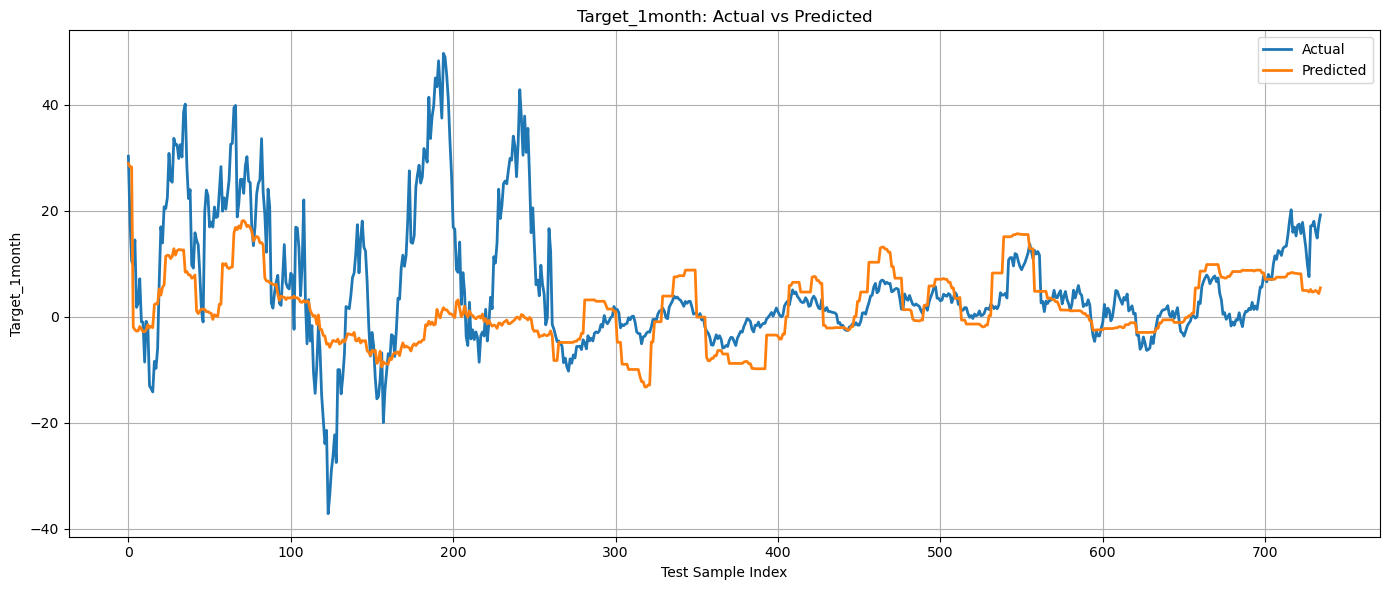

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters:
{'max_depth': None, 'n_estimators': 200}

 Evaluation:
Mean Squared Error (MSE): 582.7674
Mean Absolute Error (MAE): 18.2824
R² Score: 0.6178


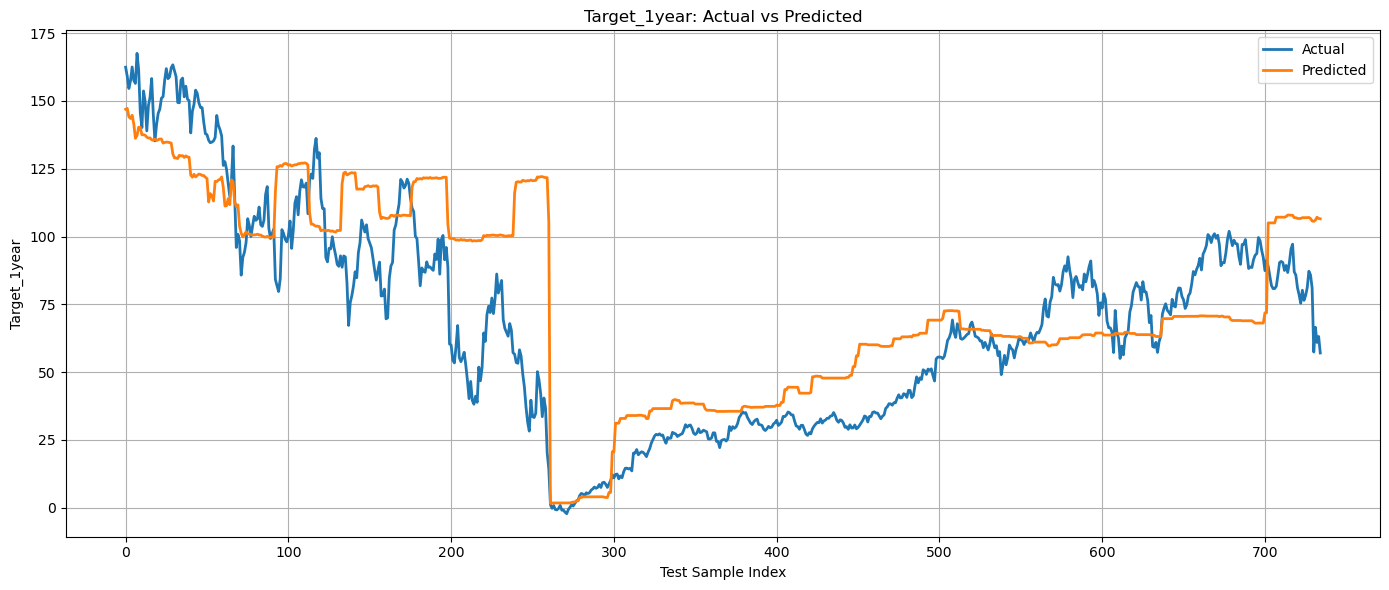

In [29]:
random_forest(df_pca, 'Target_1day')
random_forest(df_pca, 'Target_1week')
random_forest(df_pca, 'Target_1month')
random_forest(df_pca, 'Target_1year')

In [30]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

def lightgbm_model(data, target):
    df = data.copy()
    
    # 1. 타겟 처리
    remove_target_col = [col for col in df.columns if 'Target' in col]
    remove_target_col.remove(target)
    df = df.drop(columns=remove_target_col)
    df = df.dropna(subset=[target])

    # 2. 날짜 처리
    df['Date'] = pd.to_datetime(df['Date'])

    # 3. 범주형 처리
    df = pd.get_dummies(df, columns=['Ticker'], drop_first=True)

    # 4. X, y 분리
    y = df[target]
    X = df.drop(columns=['Date', target])

    # 5. 스케일링
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

    # 7. 하이퍼파라미터 그리드
    param_grid = {
        'num_leaves': [31, 63],
        'max_depth': [-1, 10, 20],
        'learning_rate': [0.1, 0.01],
        'n_estimators': [100, 200]
    }

    # 8. GridSearchCV
    model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)
    grid_search = GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               cv=3,
                               scoring='neg_mean_squared_error',
                               verbose=0,
                               n_jobs=-1)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    print("Best Parameters:")
    print(grid_search.best_params_)

    # 9. 예측
    y_pred = best_model.predict(X_test)

    # 10. 평가
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

    # 11. 시각화
    test_index = np.arange(len(y_test))
    plt.figure(figsize=(14, 6))
    plt.plot(test_index, y_test.values, label='Actual', linewidth=2)
    plt.plot(test_index, y_pred, label='Predicted', linewidth=2)
    plt.title(f'{target}: Actual vs Predicted (LightGBM)')
    plt.xlabel('Test Sample Index')
    plt.ylabel(target)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30432
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 345
[LightGBM] [Info] Start training from score 0.007188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011318 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 30432
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 345
[LightGBM] [Info] Start training from score 0.007188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.081989 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

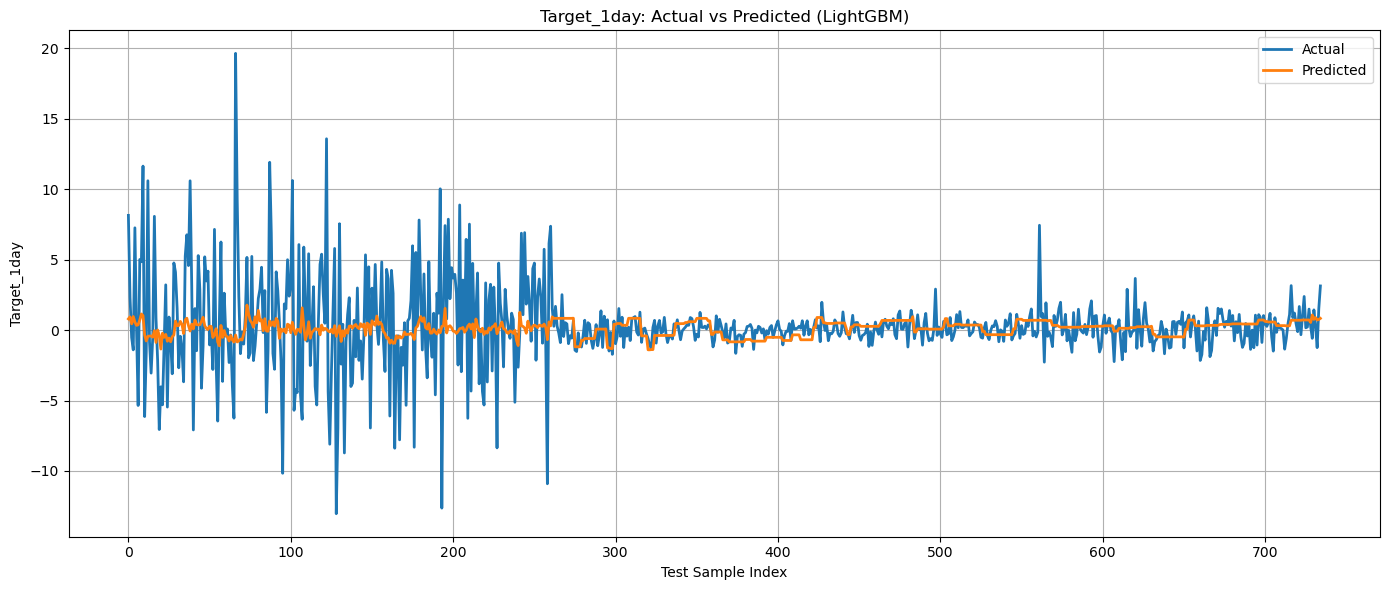

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30432
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Start training from score 0.063652
[LightGBM] [Info] Total Bins 33291
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 344
[LightGBM] [Info] Start training from score 0.346034
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

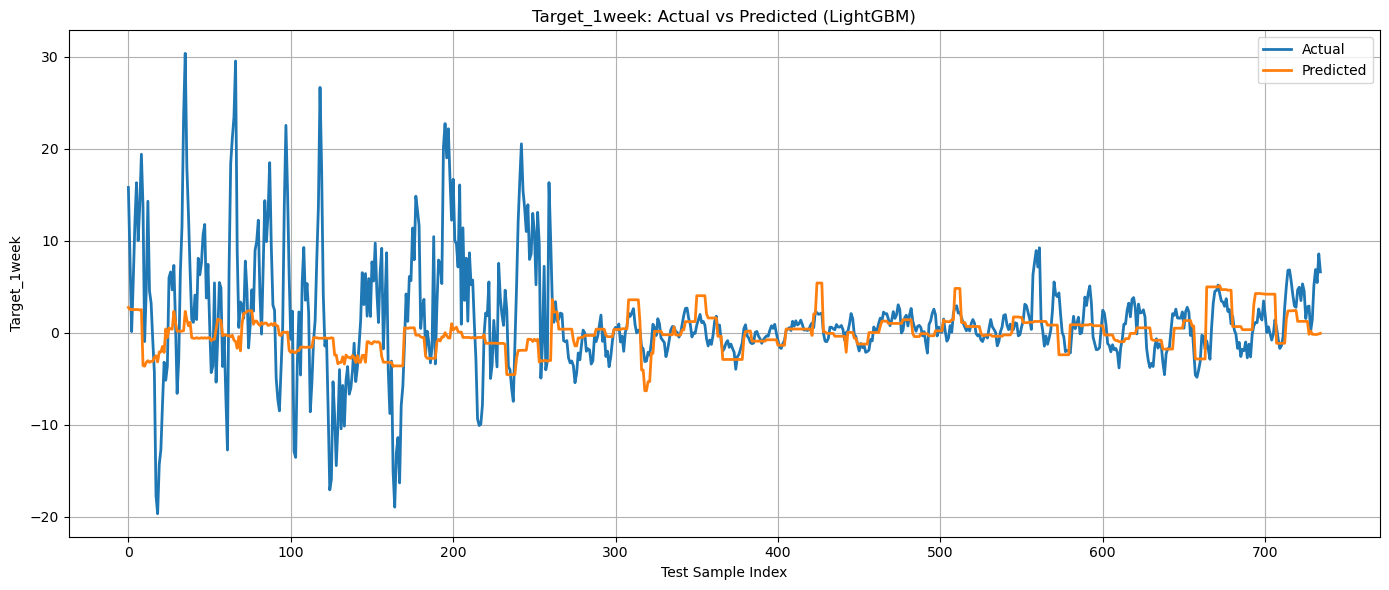

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33291
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33291
[LightGBM] [Info] Total Bins 30432
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 344
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011245 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

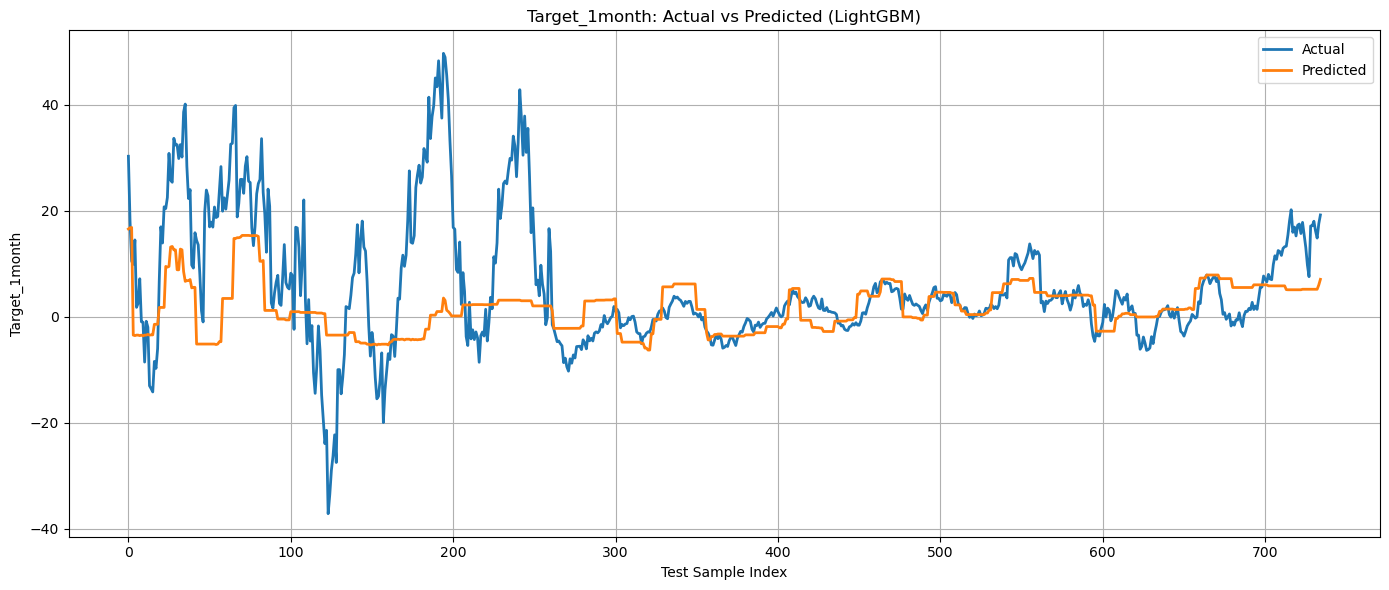

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33291
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 344
[LightGBM] [Info] Start training from score 33.239346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 30432
[LightGBM] [Info] Total Bins 30432
[LightGBM] [Info] Number of data points in the train set: 1958, number of used features: 345
[LightGBM] [Info] Number of data points i

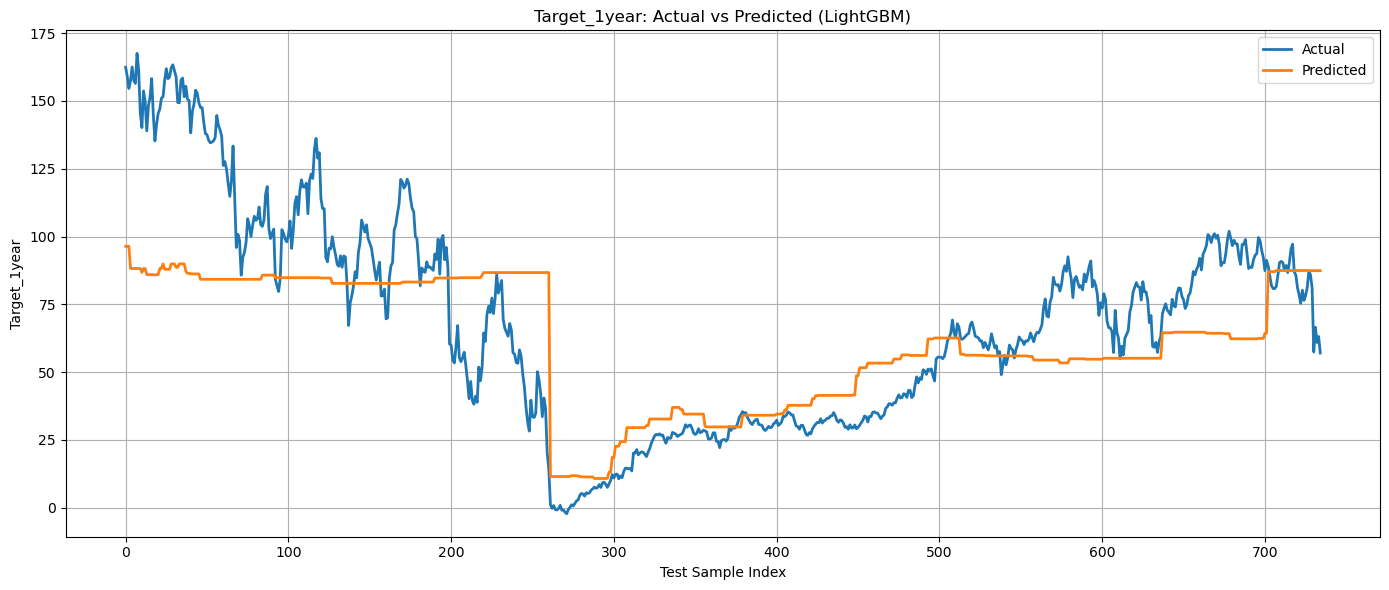

In [31]:
lightgbm_model(df_pca, 'Target_1day')
lightgbm_model(df_pca, 'Target_1week')
lightgbm_model(df_pca, 'Target_1month')
lightgbm_model(df_pca, 'Target_1year')